In [1]:
import sys,os
import torch
import yaml
import logging
from pydantic import ValidationError
from typing import List, Tuple

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.HAEA.datasets.seq2seq_dataset import Seq2SeqDataset
from models.HAEA.training.configs import FinetuningConfig
from models.HAEA.training.configs import FinetuningRunConfig
from models.HAEA.training.lightning import FinetuningModule, TrainModule


def get_normal_dataset(config: FinetuningConfig) -> Tuple[Seq2SeqDataset, torch.Tensor, torch.Tensor]:
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    vars = config.air_variable + config.surface_variable + config.only_input_variable + config.constant_variable

    weather = WeatherDataset(config.train_start, config.train_end, device=device, download_variables=vars, download_levels=config.levels)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    
    source, mean_std, var_vocab = weather.load_one(config.air_variable, config.surface_variable, config.only_input_variable, 
                                        config.constant_variable, level=config.levels)
    var_list = var_vocab.get_code(vars)

    dataset = Seq2SeqDataset(source, config.time_len, n_only_input=len(config.only_input_variable)+len(config.constant_variable))
    return dataset, mean_std, var_list


config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/finetuning_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: FinetuningRunConfig = FinetuningRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")


dataset, mean_std, var_list = get_normal_dataset(config.training)

데이터셋 불러오는 중...
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                    (time: 87649, latitude: 36, longitude: 36,
                                level: 13)
Coordinates:
  * latitude                   (latitude) float64 20.04 20.74 ... 43.95 44.65
  * level                      (level) int64 50 100 150 200 ... 700 850 925 1000
  * longitude                  (longitude) float64 115.3 116.0 ... 139.2 139.9
  * time                       (time) datetime64[ns] 2013-01-01 ... 2023-01-01
Data variables: (12/14)
    10m_u_component_of_wind    (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    10m_v_component_of_wind    (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    2m_temperature             (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    geopotential               (time, level, latitude, longitude) float32 dask.array<chunksize=(256, 13, 36, 36),

100%|██████████| 12/12 [00:33<00:00,  2.82s/it]


35.53422 sec


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(loss: torch.Tensor, title, isAIR = False):
    if isAIR:
        loss = loss.swapaxes(0, 1)
    print(loss.shape)
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

In [16]:
%load_ext autoreload
%autoreload 2

from models.HAEA.training.lightning import TrainModule, get_tgt_mask

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/HAEA/checkpoint/pretrained/epoch=4-step=87625.ckpt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensor([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  97,  95,  96, 100, 102, 105])


/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [17]:
def predict(model: TrainModule, batch, var_list, device):
    model.model.eval()

    var_list = var_list + 4
    print(var_list)
    src = batch['source'].to(device).unsqueeze(0)
    src_id = batch['source_id'].to(device)
    label = batch['target'].to(device).unsqueeze(0)
    label_id = batch['target_id'].to(device)

    tgt_id = label_id[:1]
    tgt = label[:, 0].unsqueeze(1)

    for i in range(1, config.training.time_len):
        tgt_mask = get_tgt_mask(var_list.size(0), i).to(device)
        predict = model.model(src, src_id, tgt, tgt_id, var_list, tgt_mask)
        # predict.shape = (batch, i * var + 1, hidden)
        predict = predict[:, -var_list.size(0):].unsqueeze(1)
        tgt = torch.cat([tgt, predict], dim=1)
        tgt_id = label_id[:i+1]
    
    label = label[:, 1:]
    
    tgt = tgt.view(tgt.size(0), config.training.time_len, var_list.size(0), tgt.size(-1))
    # loss.shape = (batch, time_len * var_len, 1450)
    loss = model.calculate_sqare_loss(tgt, label)
    # loss.shape = (batch, var_len, time_len, 1450)
    loss = loss.swapaxes(1, 2)
    # loss.shape = (batch, var_len, time_len)
    loss = torch.mean(loss, dim=-1)
    # loss.shape = (var_len, batch, time_len)
    loss = loss.swapaxes(0, 1)

    src.cpu().detach()

    label.cpu().detach()
    predict.cpu().detach()
    loss = loss.cpu().detach()
    
    return loss

In [18]:
device = ("cuda" if torch.cuda.is_available() else "cpu" )
device = torch.device(device)
loss = predict(model, dataset[2], var_list, device)

tensor([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  97,  95,  96, 100, 102, 105])


TypeError: iteration over a 0-d tensor

In [18]:
loss = loss.squeeze(1)
print(loss.shape)

torch.Size([48, 12])


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(loss: torch.Tensor, title, isAIR = False):
    if isAIR:
        loss = loss.swapaxes(0, 1)
    print(loss.shape)
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

torch.Size([12])


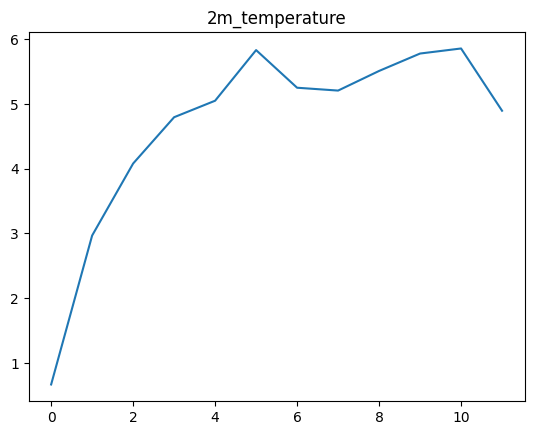

torch.Size([12])


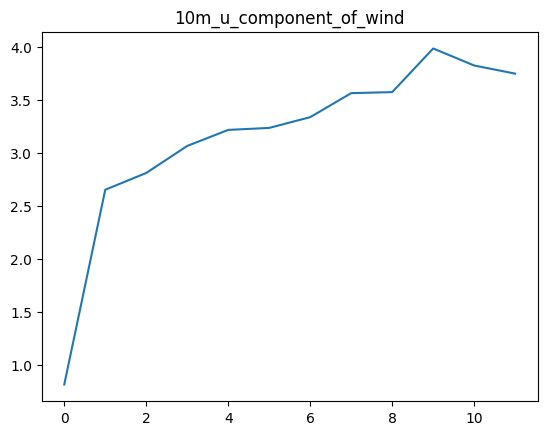

torch.Size([12])


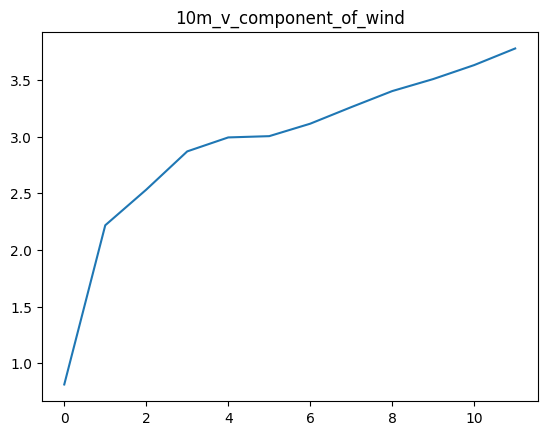

torch.Size([12])


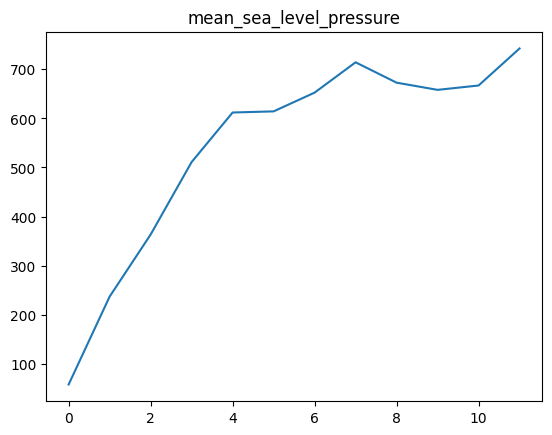

torch.Size([12])


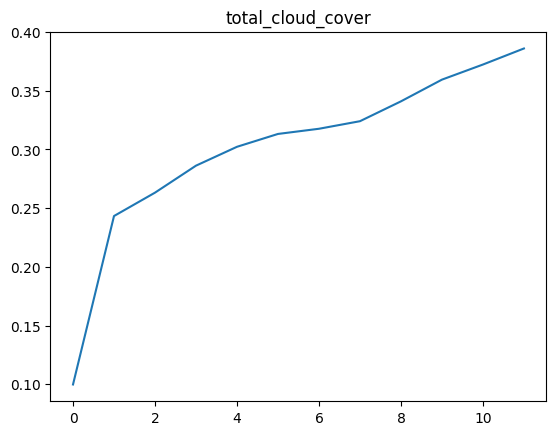

torch.Size([12])


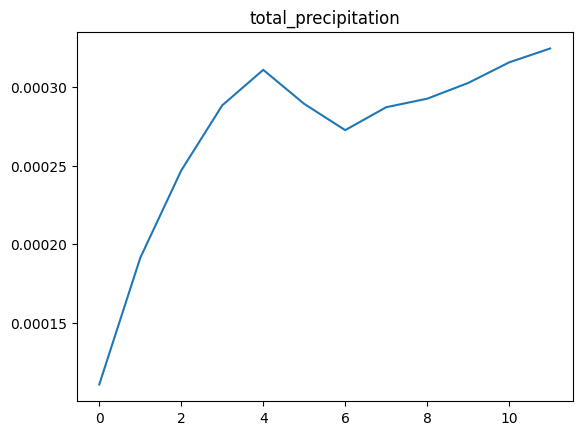

In [20]:
for i, var in enumerate(config.training.surface_variable):
        idx = len(config.training.air_variable) * len(config.training.levels) + i
        visualize(torch.sqrt(loss[idx]), var, isAIR=False)